In [1]:
import functools
import os
import pickle
import time
from argparse import Namespace
import sys

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt

from absl import logging
logging.set_verbosity(logging.INFO)


sys.path.append('./deq-jax')
from src.mnist_fcn import mnist_dataset
from src.mnist_fcn.mnist_train import build_forward_fn, ce_loss_fn, Updater, CheckpointingUpdater

sys.path.append('./spectral-density')
import density as density_lib
import lanczos as lanczos
import hessian_computation as hessian_computation

# Load Model

In [19]:
FLAGS = Namespace()
FLAGS.checkpoint_dir = '/tmp/haiku-mnist'

FLAGS.use_deq = True
FLAGS.custom_vjp = False
FLAGS.max_iter = 15
FLAGS.feedfwd_layers = 12
FLAGS.d_model = 32

FLAGS.batch_size = 16
FLAGS.learning_rate = 1e-3
FLAGS.grad_clip_value = 0.25

In [20]:
# Create the dataset.
train_dataset = mnist_dataset.load("train", is_training=True, batch_size=FLAGS.batch_size)
test_dataset = mnist_dataset.load("test", is_training=False, batch_size=10000)

# Set up the model, loss, and updater.
forward_fn = build_forward_fn(FLAGS.d_model, FLAGS.use_deq, FLAGS.custom_vjp, FLAGS.max_iter, FLAGS.feedfwd_layers)
forward_fn = hk.transform(forward_fn)
loss_fn = functools.partial(ce_loss_fn, forward_fn.apply)

optimizer = optax.chain(
    optax.clip_by_global_norm(FLAGS.grad_clip_value),
    optax.adam(FLAGS.learning_rate, b1=0.9, b2=0.99))

updater = Updater(forward_fn.init, loss_fn, optimizer)
updater = CheckpointingUpdater(updater, FLAGS.checkpoint_dir)

# Initialize parameters.
logging.info('Initializing parameters...')
rng = jax.random.PRNGKey(428)
data = next(train_dataset)
state = updater.init(rng, data)

params = state['params']

logging.info('# of params: {}'.format(sum([p.size for p in jax.tree_leaves(params)])))

INFO:absl:Load dataset info from /h/ryoungj/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/h/ryoungj/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset for split train, from /h/ryoungj/tensorflow_datasets/mnist/3.0.1
INFO:absl:Load dataset info from /h/ryoungj/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/h/ryoungj/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset for split test, from /h/ryoungj/tensorflow_datasets/mnist/3.0.1
INFO:absl:Initializing parameters...
INFO:absl:Loading checkpoint from /tmp/haiku-mnist/checkpoint_0050000.pkl
INFO:absl:# of params: 26474


# Plot Hessian Spectrum

In [21]:
num_train = 60000
num_batches = num_train // FLAGS.batch_size

# make a generator that yields 1/60th (1000 examples)
batches_list = [next(train_dataset) for i in range(num_batches // 60)]

def batches_fn():
    for b in batches_list:
        yield b
        
def loss_fn_no_rng(params, data):
    return loss_fn(params, rng, data)

In [22]:
# Hessian-vector product function + Lanczos 
order = 90
hvp, unravel, num_params = hessian_computation.get_hvp_fn(loss_fn_no_rng, params, batches_fn)
hvp_cl = lambda v: hvp(params, v) / len(batches_list) # Match the API required by lanczos_alg

In [23]:
print("num_params: {}".format(num_params))
start = time.clock()
hvp_cl(np.ones(num_params)) # first call of a jitted function compiles it
end = time.clock()
print("hvp compile time: {}".format(end-start))
start = time.clock()
hvp_cl(2*np.ones(num_params)) # second+ call will be much faster
end = time.clock()
print("hvp compute time: {}".format(end-start))

num_params: 26474


/scratch/ssd002/home/ryoungj/conda_envs/deq-jax/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/scratch/ssd002/home/ryoungj/conda_envs/deq-jax/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/scratch/ssd002/home/ryoungj/conda_envs/deq-jax/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


hvp compile time: 20.04783199999997
hvp compute time: 17.435158


/scratch/ssd002/home/ryoungj/conda_envs/deq-jax/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [24]:
rng, split = jax.random.split(rng)
start = time.clock()
tridiag, vecs = lanczos.lanczos_alg(hvp_cl, num_params, order, split)
end = time.clock()
print("Lanczos time: {}".format(end-start)) # this should be ~order * hvp compute time
density, grids = density_lib.tridiag_to_density([tridiag], grid_len=10000, sigma_squared=1e-5)

/scratch/ssd002/home/ryoungj/conda_envs/deq-jax/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/scratch/ssd002/home/ryoungj/conda_envs/deq-jax/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


Lanczos time: 1501.036157


In [25]:
def plot(grids, density, label=None):
    plt.semilogy(grids, density, label=label)
    plt.ylim(1e-10, 1e2)
    plt.ylabel("Density")
    plt.xlabel("Eigenvalue")
    plt.legend()

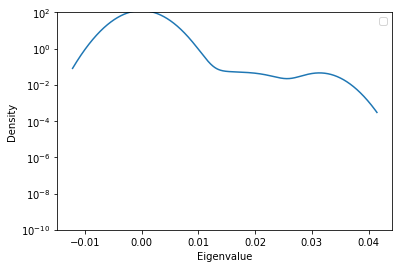

In [26]:
plot(grids, density)